## Imports

In [1]:
# Imports

import torch
from torch import nn
import matplotlib.pyplot as plt


print(torch.__version__)

2.5.1+cu121


In [2]:
# Setting the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

## Data

In [3]:
# Tensor in gpu

X = torch.arange(start = 0, end = 1, step = 0.02, device = device).unsqueeze(dim=1)

weight = 0.3
bias = 0.7

y = weight * X + bias

In [4]:
# train test split

rat2ind = int(len(X) * 0.8)

x_train, y_train = X[ : rat2ind], y[ : rat2ind]
x_test, y_test = X[ rat2ind : ], y[ rat2ind : ]

In [5]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape


(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

In [6]:
# Creating the model

class LinearRegressionModel(nn.Module):

  def __init__(self):
    super().__init__()

    # self.weight = nn.Parameter(torch.rand(1, requires_grad = True, device = device, dtype = torch.float))
    # self.bias = nn.Parameter(torch.rand(1, device =device, requires_grad = True, dtype = torch.float))#
    self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

  def forward(self, x: torch.Tensor)->torch.Tensor:

    return self.linear_layer(x)
    # return self.weight * x + self.bias

In [7]:
# Initialising the model

torch.manual_seed(42)

model =  LinearRegressionModel()

# setting the model to cuda if available

model.to(device)

# loss functions

loss_fn = torch.nn.L1Loss()

# Optimizer

optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [8]:
# training loop

epoch_count = []
loss_values = []
test_loss_values = []
predictions = {}


def trainer(epochs, x_train = x_train, x_test = x_test, y_train = y_train, y_test = y_test):

  if len(epoch_count) != 0:

    start = epoch_count[-1]+1
    end = start + epochs

  else:
    start = 1
    end = epochs + 1


  for epoch in range(start, end):

    # training mode
    model.train()

    # forward pass
    y_pred = model(x_train)

    # calculate loss
    loss = loss_fn(y_pred, y_train)

    # reset optimizer
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # optimizer step
    optimizer.step()

    if epoch % 10  == 0 :

      # eval mode
      model.eval()

      # inference
      with torch.inference_mode():
        test_pred = model(x_test)
        predictions[f"epoch{epoch}"] = test_pred

      test_loss = loss_fn(test_pred, y_test)

      epoch_count.append(epoch)
      loss_values.append(loss.item())
      test_loss_values.append(test_loss.item())

  return [epoch_count, loss_values, test_loss_values]


In [9]:
# training for 200

[epoch_count, loss_values, test_loss_values] = trainer(200)

In [10]:
# Plotting functions

def plot_predictions(x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, predictions=None):

  plt.scatter(x = x_train, y = y_train, c = "g", label = "Train")
  plt.scatter(x = x_test, y= y_test, c = "r", label = "test")

  if predictions != None:
    for epoch, prediction in predictions.items():
      plt.scatter(x = x_test, y=prediction, label = epoch)
  plt.xlabel("Input")
  plt.ylabel("Target")
  plt.title("Linear Regression")
  plt.legend(prop={"size":10})


def plot_losses(epoch_count, loss_values, test_loss_values):

  plt.plot(epoch_count, loss_values, c="g", label = "train-loss")
  plt.plot(epoch_count, test_loss_values, c="r", label = "test-loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Epochs vs loss")
  plt.legend(prop = {"size":10})


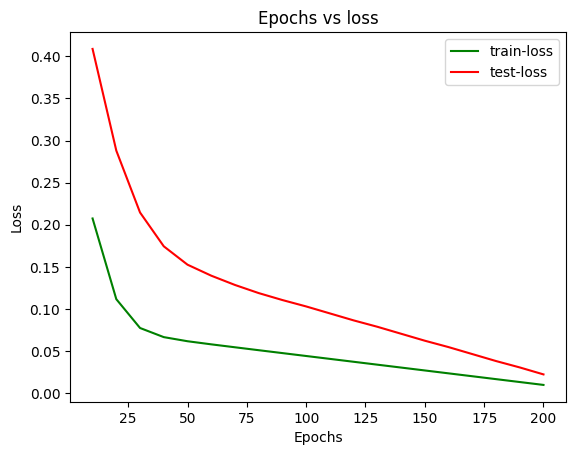

In [11]:
# loss vs epochs

plot_losses(epoch_count, loss_values, test_loss_values)

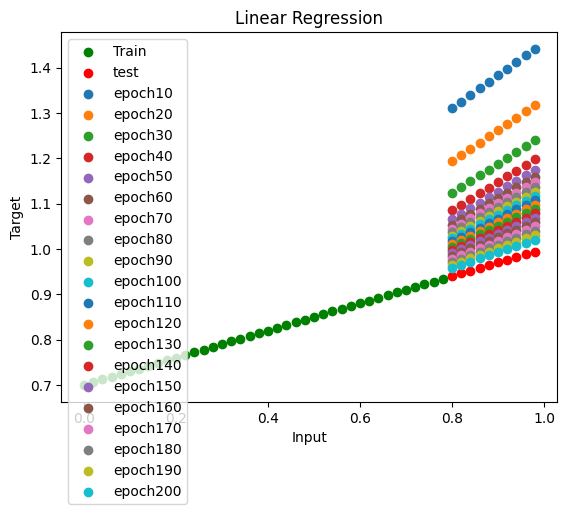

In [12]:
# plot predicitons
x_train_cpu = x_train.cpu()
x_test_cpu = x_test.cpu()
y_train_cpu = y_train.cpu()
y_test_cpu = y_test.cpu()
predictions_cpu = output = {key: value.cpu() for key, value in predictions.items()}
plot_predictions(x_train = x_train_cpu, x_test = x_test_cpu, y_train = y_train_cpu, y_test = y_test_cpu,predictions = predictions_cpu)

## saving the model

In [14]:
from pathlib import Path

MODEL_PATH = Path("model")

MODEL_PATH.mkdir(exist_ok = True, parents = True)

MODEL_NAME = "LinearModelep200.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

OPTIM_NAME = "LinearModelOptim.pth"

OPTIM_SAVE_PATH = MODEL_PATH / OPTIM_NAME


# saving the model

torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

# saving the optimizer

torch.save(obj = optimizer.state_dict(), f = OPTIM_SAVE_PATH)

In [17]:
# Loading the saved model

model = LinearRegressionModel()

optimizer = torch.optim.SGD(params = model.parameters())

model.load_state_dict(torch.load("/content/model/LinearModelep200.pth", weights_only = True))

optimizer.load_state_dict(torch.load("/content/model/LinearModelOptim.pth", weights_only = True))

model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [18]:
model.eval()

with torch.inference_mode():
  y_pred = model(x_test)

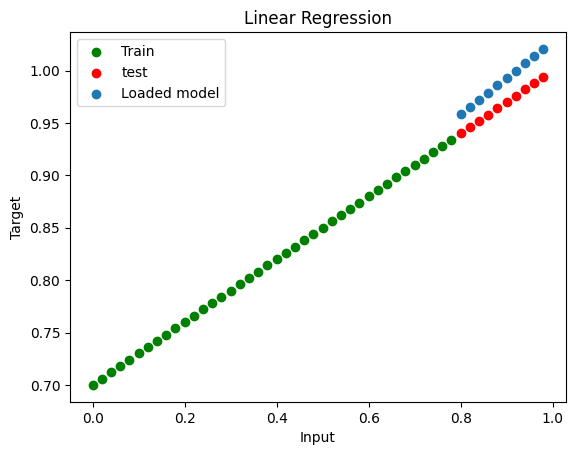

In [19]:
x_train_cpu = x_train.cpu()
x_test_cpu = x_test.cpu()
y_train_cpu = y_train.cpu()
y_test_cpu = y_test.cpu()
predictions_cpu = {"Loaded model": y_pred.cpu()}
plot_predictions(x_train = x_train_cpu, x_test = x_test_cpu, y_train = y_train_cpu, y_test = y_test_cpu,predictions = predictions_cpu)